# Prerequisites

In [1]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

import numpy as np

# DeepSpeed ZeRO-3
import deepspeed
from deepspeed.accelerator import get_accelerator

[2024-05-08 08:55:40,277] [INFO] [real_accelerator.py:203:get_accelerator] Setting ds_accelerator to cuda (auto detect)


/home/it/anaconda3/envs/genety/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


 [WARNING]  async_io requires the dev libaio .so object and headers but these were not found.
 [WARNING]  If libaio is already installed (perhaps from source), try setting the CFLAGS and LDFLAGS environment variables to where it can be found.
 [WARNING]  Please specify the CUTLASS repo directory as environment variable $CUTLASS_PATH


/home/it/anaconda3/envs/genety/compiler_compat/ld: /lib/x86_64-linux-gnu/libc.so.6: undefined reference to `_dl_audit_symbind_alt@GLIBC_PRIVATE'
/home/it/anaconda3/envs/genety/compiler_compat/ld: /lib/x86_64-linux-gnu/libc.so.6: undefined reference to `__nptl_change_stack_perm@GLIBC_PRIVATE'
/home/it/anaconda3/envs/genety/compiler_compat/ld: /lib/x86_64-linux-gnu/libc.so.6: undefined reference to `_dl_find_dso_for_object@GLIBC_PRIVATE'
/home/it/anaconda3/envs/genety/compiler_compat/ld: /lib/x86_64-linux-gnu/libc.so.6: undefined reference to `_dl_fatal_printf@GLIBC_PRIVATE'
/home/it/anaconda3/envs/genety/compiler_compat/ld: /lib/x86_64-linux-gnu/libc.so.6: undefined reference to `_dl_exception_create@GLIBC_PRIVATE'
/home/it/anaconda3/envs/genety/compiler_compat/ld: /lib/x86_64-linux-gnu/libc.so.6: undefined reference to `__tunable_get_val@GLIBC_PRIVATE'
/home/it/anaconda3/envs/genety/compiler_compat/ld: /lib/x86_64-linux-gnu/libc.so.6: undefined reference to `_dl_audit_preinit@GLIBC_PRI

 [WARNING]  sparse_attn requires a torch version >= 1.5 and < 2.0 but detected 2.3
 [WARNING]  using untested triton version (2.3.0), only 1.0.0 is known to be compatible


/home/it/anaconda3/envs/genety/lib/python3.11/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [3]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print(device)

cuda


In [4]:
(free_memory, global_memory) = torch.cuda.mem_get_info()
print(f"Free(GB): {free_memory/1024/1024/1024}, Global(GB): {global_memory/1024/1024/1024}, Free(%): {free_memory/global_memory}")

Free(GB): 23.25750732421875, Global(GB): 23.64971923828125, Free(%): 0.9834157898404292


# Load Excel File

In [5]:
import pandas as pd
master_df = pd.read_excel('./DATASETS/Training_Dataset.xlsx')
master_df.head()

,Type,Identity,Text,A2-Unambiguous,A4-Tolerances,A5-Sources specified,E1
0,GSS_CONNECTIVITY,SRD_GSS_FUNC_61,The User and Rights Administration HMI shall p...,1,na,na,1
1,Cobham_ATR,SHLR-ATR2146,The Network Function shall support WiFi 802.11...,1,na,na,1
2,Cobham_ATR,SHLR-ATR797,The PwrCon software shall monitor the output v...,1,na,na,1
3,Cobham_ATR,SHLR-ATR3013,"When prompted, the TETRA Software shall place ...",1,na,na,1
4,Cobham_ATR,SHLR-ATR3198,The TETRA software shall allow users to select...,1,na,na,1


In [6]:
model_df = master_df[['E1','Text']].copy()
model_df.head()

,E1,Text
0,1,The User and Rights Administration HMI shall p...
1,1,The Network Function shall support WiFi 802.11...
2,1,The PwrCon software shall monitor the output v...
3,1,"When prompted, the TETRA Software shall place ..."
4,1,The TETRA software shall allow users to select...


In [7]:
model_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3255 entries, 0 to 3254
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   E1      3255 non-null   int64 
 1   Text    3255 non-null   object
dtypes: int64(1), object(1)
memory usage: 51.0+ KB


In [8]:
model_df_label1 = model_df.query('E1 == 1')
len(model_df_label1)

2127

In [9]:
model_df_label0 = model_df.query('E1 == 0')
len(model_df_label0)

1128

In [10]:
model_df = pd.concat([model_df_label1[:1500],model_df_label0])

# Data process and tokenizer

In [11]:
from sklearn.model_selection  import train_test_split
train_df, test_df = train_test_split(model_df, test_size=0.1, shuffle=True)

train_iter = iter(list(train_df.itertuples(index=False, name=None)))
test_iter = iter(list(test_df.itertuples(index=False, name=None)))

In [12]:
len(train_df)

2365

In [13]:
tokenizer = torch.hub.load(
    "huggingface/pytorch-transformers",
    "tokenizer",
    "microsoft/Phi-2",
)

Using cache found in /home/it/.cache/torch/hub/huggingface_pytorch-transformers_main
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [14]:
tokenizer

CodeGenTokenizerFast(name_or_path='microsoft/Phi-2', vocab_size=50257, model_max_length=2048, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<|endoftext|>', 'eos_token': '<|endoftext|>', 'unk_token': '<|endoftext|>'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	50256: AddedToken("<|endoftext|>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	50257: AddedToken("                               ", rstrip=False, lstrip=False, single_word=False, normalized=True, special=False),
	50258: AddedToken("                              ", rstrip=False, lstrip=False, single_word=False, normalized=True, special=False),
	50259: AddedToken("                             ", rstrip=False, lstrip=False, single_word=False, normalized=True, special=False),
	50260: AddedToken("                            ", rstrip=False, lstrip=False, single_word=False, normalized=True, special=False),
	50261: AddedToken("            

# Dataset iterator

In [15]:
train_iter = iter(list(train_df.itertuples(index=False, name=None)))
test_iter = iter(list(test_df.itertuples(index=False, name=None)))

In [16]:
next(train_iter)

(1,
 'When an AAMF_GAMF_XFER_SESSION(IRS_108) with Opcode END(0x6E) message is received the GAMF director shall create a session data available to the GCS API with revision, last published date and type. If the session is already available to the GCS API increment revision, update the published date and add type if is not already added.')

In [17]:
from torch.utils.data import DataLoader

tokenizer.pad_token = tokenizer.eos_token

def collate_batch(batch):
    # Get label and text
    y, x = list(zip(*batch))

    # Create list with indices from tokeniser

    encoded_x = tokenizer(x, padding=True, truncation=True)
    encoded_x.input_ids = torch.tensor(encoded_x.input_ids).to(device)
    encoded_x.attention_mask = torch.tensor(encoded_x.attention_mask).to(device)  
    
    # Prepare the labels, by subtracting 1 to get them in the range 0-3
    return encoded_x, torch.tensor(y, dtype=torch.long).to(device)

In [18]:
train_iter = iter(list(train_df.itertuples(index=False, name=None)))
first = next(train_iter)
second = next(train_iter)

print(first)
print(second)

collate_batch([first, second])

(1, 'When an AAMF_GAMF_XFER_SESSION(IRS_108) with Opcode END(0x6E) message is received the GAMF director shall create a session data available to the GCS API with revision, last published date and type. If the session is already available to the GCS API increment revision, update the published date and add type if is not already added.')
(1, 'ITCM shall detect fault in hardwire connection with trailer brake actuator.')


({'input_ids': [[2215, 281, 317, 2390, 37, 62, 38, 2390, 37, 62, 55, 24302, 62, 50, 47621, 7, 4663, 50, 62, 15711, 8, 351, 8670, 8189, 23578, 7, 15, 87, 21, 36, 8, 3275, 318, 2722, 262, 49965, 37, 3437, 2236, 2251, 257, 6246, 1366, 1695, 284, 262, 402, 7902, 7824, 351, 18440, 11, 938, 3199, 3128, 290, 2099, 13, 1002, 262, 6246, 318, 1541, 1695, 284, 262, 402, 7902, 7824, 18703, 18440, 11, 4296, 262, 3199, 3128, 290, 751, 2099, 611, 318, 407, 1541, 2087, 13], [2043, 24187, 2236, 4886, 8046, 287, 1327, 21809, 4637, 351, 12268, 20439, 43840, 1352, 13, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 5025

# Define the model

In [52]:
model = torch.hub.load(
    "huggingface/pytorch-transformers",
    "modelForSequenceClassification",
    "microsoft/Phi-2",
)

Using cache found in /home/it/.cache/torch/hub/huggingface_pytorch-transformers_main


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Some weights of PhiForSequenceClassification were not initialized from the model checkpoint at microsoft/Phi-2 and are newly initialized: ['model.layers.20.self_attn.query_key_value.bias', 'model.layers.22.self_attn.query_key_value.weight', 'model.layers.18.self_attn.query_key_value.bias', 'model.layers.6.self_attn.query_key_value.weight', 'model.layers.30.self_attn.query_key_value.weight', 'model.layers.17.self_attn.query_key_value.bias', 'model.layers.16.self_attn.query_key_value.bias', 'model.layers.27.self_attn.query_key_value.weight', 'model.layers.2.self_attn.query_key_value.bias', 'model.layers.21.self_attn.query_key_value.bias', 'model.layers.9.self_attn.query_key_value.bias', 'model.layers.0.self_attn.query_key_value.bias', 'model.layers.17.self_attn.query_key_value.weight', 'model.layers.3.self_attn.query_key_value.bias', 'model.layers.25.self_attn.query_key_value.bias', 'model.layers.16.self_attn.query_key_value.weight', 'model.layers.15.self_attn.query_key_value.weight', 'm

In [53]:
model

PhiForSequenceClassification(
  (model): PhiModel(
    (embed_tokens): Embedding(51200, 2560)
    (embed_dropout): Dropout(p=0.0, inplace=False)
    (layers): ModuleList(
      (0-31): 32 x PhiDecoderLayer(
        (self_attn): PhiAttention(
          (query_key_value): Linear(in_features=2560, out_features=7680, bias=True)
          (dense): Linear(in_features=2560, out_features=2560, bias=True)
          (attention_dropout): Dropout(p=0.0, inplace=False)
          (rotary_emb): PhiRotaryEmbedding()
        )
        (mlp): PhiMLP(
          (activation_fn): NewGELUActivation()
          (fc1): Linear(in_features=2560, out_features=10240, bias=True)
          (fc2): Linear(in_features=10240, out_features=2560, bias=True)
        )
        (input_layernorm): LayerNorm((2560,), eps=1e-05, elementwise_affine=True)
        (resid_dropout): Dropout(p=0.1, inplace=False)
      )
    )
    (final_layernorm): LayerNorm((2560,), eps=1e-05, elementwise_affine=True)
  )
  (score): Linear(in_feat

In [21]:
num_class = len(set([label for (label, text) in train_iter]))
num_class

2

In [22]:
for i, parameter in enumerate(model.parameters()):
    parameter.requires_grad = False

In [54]:
model.score = nn.Sequential(
    nn.Linear(in_features=2560, out_features=2560),
    nn.Dropout(),
    nn.Linear(in_features=2560, out_features=2),
)
model.config.pad_token_id = tokenizer.pad_token_id

In [55]:
model

PhiForSequenceClassification(
  (model): PhiModel(
    (embed_tokens): Embedding(51200, 2560)
    (embed_dropout): Dropout(p=0.0, inplace=False)
    (layers): ModuleList(
      (0-31): 32 x PhiDecoderLayer(
        (self_attn): PhiAttention(
          (query_key_value): Linear(in_features=2560, out_features=7680, bias=True)
          (dense): Linear(in_features=2560, out_features=2560, bias=True)
          (attention_dropout): Dropout(p=0.0, inplace=False)
          (rotary_emb): PhiRotaryEmbedding()
        )
        (mlp): PhiMLP(
          (activation_fn): NewGELUActivation()
          (fc1): Linear(in_features=2560, out_features=10240, bias=True)
          (fc2): Linear(in_features=10240, out_features=2560, bias=True)
        )
        (input_layernorm): LayerNorm((2560,), eps=1e-05, elementwise_affine=True)
        (resid_dropout): Dropout(p=0.1, inplace=False)
      )
    )
    (final_layernorm): LayerNorm((2560,), eps=1e-05, elementwise_affine=True)
  )
  (score): Sequential(
  

# Train and eval functions

In [25]:
from datetime import datetime, date
import time

def train(model, dataloader, epoch):
    
    model.train()
    total_acc, total_count = 0, 0
    log_interval = 5
    start_time = time.time()
    total_loss = 0


    for idx, (data, label) in enumerate(dataloader):         
        optimizer.zero_grad()
        
        outputs = model(input_ids=data.input_ids, attention_mask=data.attention_mask)
        predicted_label = outputs.logits
        loss = criterion(predicted_label, label)
        
        # Deepspeed model engine, backward pass 
        model.backward(loss)
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
        
        # Deepspeed model engine, optimizer step
        model.step()
        
        total_acc += (predicted_label.argmax(1) == label).sum().item()
        total_count += label.size(0)
        total_loss += loss.item()
        
        # Deepspeed model engine, empty cache
        model.empty_partition_cache()
        
    return total_acc / total_count, total_loss / total_count
        

def evaluate(model, dataloader):
    model.eval()
    total_acc, total_count = 0, 0

    with torch.no_grad():
        for idx, (data, label) in enumerate(dataloader):      
            outputs = model(input_ids=data.input_ids, attention_mask=data.attention_mask)
            predicted_label = outputs.logits
            loss = criterion(predicted_label, label)
            
            total_acc += (predicted_label.argmax(1) == label).sum().item()
            total_count += label.size(0)

    return total_acc / total_count, loss.item() / total_count

# Deepspeed

In [26]:
deepspeed_config = {
    "optimizer": {
        "type": "Adam",
        "params": {
            "lr": 0.001,
            "betas": [
                0.8,
                0.999
            ],
            "eps": 1e-8,
            "weight_decay": 3e-7,
        },
    },
    "scheduler": {
        "type": "WarmupLR",
        "params": {
            "warmup_min_lr": 0,
            "warmup_max_lr": 0.001,
            "warmup_num_steps": 1000,
        },
    },
    "train_batch_size": 16,
    # "train_micro_batch_size_per_gpu": "auto",
    # "gradient_accumulation_steps": "auto",
    "fp16": {"enabled": True},
    "zero_optimization": {
        "stage": 3,
        "offload_optimizer": {
            "device": "cpu",
        },
        "offload_param": {
            "device": "cpu",
        },
        "allgather_partitions": True,
        "allgather_bucket_size": 2e8,
        "reduce_scatter": True,
        "reduce_bucket_size": 2e8,
        "overlap_comm": True,
        "load_from_fp32_weights": True,
        "gather_16bit_weights_on_model_save": True,
        "contiguous_gradients": True,
        "stage3_prefetch_bucket_size": 0,
    },
    "gradient_accumulation_steps": 1,
    "train_batch_size": 16,
}

# Initialize DeepSpeed Engine
model_engine, optimizer, _, lr_scheduler = deepspeed.initialize(
    model=model,
    model_parameters=model.parameters(),
    config=deepspeed_config,
)
model_engine

[2024-05-08 08:55:46,870] [INFO] [logging.py:96:log_dist] [Rank -1] DeepSpeed info: version=0.14.2, git-hash=unknown, git-branch=unknown
[2024-05-08 08:55:46,870] [INFO] [comm.py:637:init_distributed] cdb=None
[2024-05-08 08:55:46,871] [INFO] [comm.py:652:init_distributed] Not using the DeepSpeed or dist launchers, attempting to detect MPI environment...
[2024-05-08 08:55:47,147] [INFO] [comm.py:702:mpi_discovery] Discovered MPI settings of world_rank=0, local_rank=0, world_size=1, master_addr=10.1.1.204, master_port=29500
[2024-05-08 08:55:47,148] [INFO] [comm.py:668:init_distributed] Initializing TorchBackend in DeepSpeed with backend nccl


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


[2024-05-08 08:55:48,504] [INFO] [logging.py:96:log_dist] [Rank 0] DeepSpeed Flops Profiler Enabled: False
[2024-05-08 08:55:49,565] [WARNING] [cpu_adam.py:84:__init__] FP16 params for CPUAdam may not work on AMD CPUs
Installed CUDA version 12.3 does not match the version torch was compiled with 12.1 but since the APIs are compatible, accepting this combination


Using /home/it/.cache/torch_extensions/py311_cu121 as PyTorch extensions root...
Detected CUDA files, patching ldflags
Emitting ninja build file /home/it/.cache/torch_extensions/py311_cu121/cpu_adam/build.ninja...
/home/it/anaconda3/envs/genety/lib/python3.11/site-packages/torch/utils/cpp_extension.py:1967: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(
Building extension module cpu_adam...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)


ninja: no work to do.
Time to load cpu_adam op: 2.1964612007141113 seconds


Loading extension module cpu_adam...


[2024-05-08 08:55:52,121] [INFO] [logging.py:96:log_dist] [Rank 0] Using DeepSpeed Optimizer param name adam as basic optimizer
[2024-05-08 08:55:52,121] [INFO] [logging.py:96:log_dist] [Rank 0] Removing param_group that has no 'params' in the basic Optimizer
[2024-05-08 08:55:52,127] [INFO] [logging.py:96:log_dist] [Rank 0] DeepSpeed Basic Optimizer = DeepSpeedCPUAdam
[2024-05-08 08:55:52,127] [INFO] [utils.py:56:is_zero_supported_optimizer] Checking ZeRO support for optimizer=DeepSpeedCPUAdam type=<class 'deepspeed.ops.adam.cpu_adam.DeepSpeedCPUAdam'>
[2024-05-08 08:55:52,127] [INFO] [logging.py:96:log_dist] [Rank 0] Creating fp16 ZeRO stage 3 optimizer, MiCS is enabled False, Hierarchical params gather False
[2024-05-08 08:55:52,127] [INFO] [logging.py:96:log_dist] [Rank 0] Creating torch.float16 ZeRO stage 3 optimizer
[2024-05-08 08:55:52,223] [INFO] [utils.py:779:see_memory_usage] Stage 3 initialize beginning
[2024-05-08 08:55:52,224] [INFO] [utils.py:780:see_memory_usage] MA 4.97

[2024-05-08 08:55:54,724] [INFO] [config.py:1000:print]   curriculum_enabled_legacy .... False
[2024-05-08 08:55:54,724] [INFO] [config.py:1000:print]   curriculum_params_legacy ..... False
[2024-05-08 08:55:54,724] [INFO] [config.py:1000:print]   data_efficiency_config ....... {'enabled': False, 'seed': 1234, 'data_sampling': {'enabled': False, 'num_epochs': 1000, 'num_workers': 0, 'curriculum_learning': {'enabled': False}}, 'data_routing': {'enabled': False, 'random_ltd': {'enabled': False, 'layer_token_lr_schedule': {'enabled': False}}}}
[2024-05-08 08:55:54,725] [INFO] [config.py:1000:print]   data_efficiency_enabled ...... False
[2024-05-08 08:55:54,725] [INFO] [config.py:1000:print]   dataloader_drop_last ......... False
[2024-05-08 08:55:54,725] [INFO] [config.py:1000:print]   disable_allgather ............ False
[2024-05-08 08:55:54,725] [INFO] [config.py:1000:print]   dump_state ................... False
[2024-05-08 08:55:54,725] [INFO] [config.py:1000:print]   dynamic_loss_sc

[2024-05-08 08:55:54,731] [INFO] [config.py:1000:print]   zero_force_ds_cpu_optimizer .. True
[2024-05-08 08:55:54,732] [INFO] [config.py:1000:print]   zero_optimization_stage ...... 3
[2024-05-08 08:55:54,732] [INFO] [config.py:986:print_user_config]   json = {
    "optimizer": {
        "type": "Adam", 
        "params": {
            "lr": 0.001, 
            "betas": [0.8, 0.999], 
            "eps": 1e-08, 
            "weight_decay": 3e-07
        }
    }, 
    "scheduler": {
        "type": "WarmupLR", 
        "params": {
            "warmup_min_lr": 0, 
            "warmup_max_lr": 0.001, 
            "warmup_num_steps": 1000
        }
    }, 
    "train_batch_size": 16, 
    "fp16": {
        "enabled": true
    }, 
    "zero_optimization": {
        "stage": 3, 
        "offload_optimizer": {
            "device": "cpu"
        }, 
        "offload_param": {
            "device": "cpu"
        }, 
        "allgather_partitions": true, 
        "allgather_bucket_size": 2.0000

DeepSpeedEngine(
  (module): PhiForSequenceClassification(
    (model): PhiModel(
      (embed_tokens): Embedding(51200, 2560)
      (embed_dropout): Dropout(p=0.0, inplace=False)
      (layers): ModuleList(
        (0-31): 32 x PhiDecoderLayer(
          (self_attn): PhiAttention(
            (query_key_value): Linear(in_features=2560, out_features=7680, bias=True)
            (dense): Linear(in_features=2560, out_features=2560, bias=True)
            (attention_dropout): Dropout(p=0.0, inplace=False)
            (rotary_emb): PhiRotaryEmbedding()
          )
          (mlp): PhiMLP(
            (activation_fn): NewGELUActivation()
            (fc1): Linear(in_features=2560, out_features=10240, bias=True)
            (fc2): Linear(in_features=10240, out_features=2560, bias=True)
          )
          (input_layernorm): LayerNorm((2560,), eps=1e-05, elementwise_affine=True)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (final_layernorm): LayerNorm((25

In [27]:
# device = "cuda:0" if torch.cuda.is_available() else "cpu"
device = get_accelerator().device_name(model_engine.local_rank)
device

'cuda:0'

# Split the dataset and run the model

In [28]:
from torch.utils.data.dataset import random_split
from torchtext.data.functional import to_map_style_dataset

BATCH_SIZE = 16  # batch size for training

train_iter = iter(list(train_df.itertuples(index=False, name=None)))
train_dataset = to_map_style_dataset(train_iter)
test_dataset = to_map_style_dataset(test_iter)
num_train = int(len(train_dataset) * 0.8)
split_train_, split_valid_ = random_split(
    train_dataset, [num_train, len(train_dataset) - num_train]
)

train_dataloader = DataLoader(
    split_train_, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch
)
valid_dataloader = DataLoader(
    split_valid_, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch
)
test_dataloader = DataLoader(
    test_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch
)

/home/it/anaconda3/envs/genety/lib/python3.11/site-packages/torchtext/data/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)


In [29]:
today = date.today().isoformat()
model_name = "phi"
checkpoint_path = f"./models/{model_name}"


# Hyperparameters
EPOCHS = 20  # epoch
# LR = 0.1 # learning rate
    
criterion = torch.nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=LR)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.1)
    
def train_with_hist(model, checkpoint_path):
    model = model.to(device)
    
    total_accu = None

    loss_hist_train, loss_hist_valid, accuracy_hist_train, accuracy_hist_valid = [], [], [], []
    for epoch in range(1, EPOCHS + 1):
        epoch_start_time = time.time()
        accu_train, loss_train = train(model, train_dataloader, epoch)
        accu_val, loss_val = evaluate(model, valid_dataloader)
        
        print({
            "epoch": epoch,
            "loss_train": loss_train,
            "loss_val": loss_val,
            "accuracy_train": accu_train,
            "accuracy_val": accu_val,
        })
        
        loss_hist_train.append(loss_train)
        loss_hist_valid.append(loss_val)
        accuracy_hist_train.append(accu_train)
        accuracy_hist_valid.append(accu_val)
        
    return loss_hist_train, loss_hist_valid, accuracy_hist_train, accuracy_hist_valid

In [30]:
import gc

gc.collect()
torch.cuda.empty_cache()

In [31]:
(free_memory, global_memory) = torch.cuda.mem_get_info()
print(f"Free(GB): {free_memory/1024/1024/1024}, Global(GB): {global_memory/1024/1024/1024}, Free(%): {free_memory/global_memory}")

Free(GB): 22.61102294921875, Global(GB): 23.64971923828125, Free(%): 0.9560799737790888


In [32]:
hist = train_with_hist(model_engine, checkpoint_path)

Adam Optimizer #0 is created with AVX512 arithmetic capability.
Config: alpha=0.001000, betas=(0.800000, 0.999000), weight_decay=0.000000, adam_w=1
[2024-05-08 08:55:55,848] [INFO] [loss_scaler.py:183:update_scale] [deepspeed] OVERFLOW! Rank 0 Skipping step. Attempted loss scale: 4294967296, reducing to 2147483648
[2024-05-08 08:55:56,506] [INFO] [loss_scaler.py:183:update_scale] [deepspeed] OVERFLOW! Rank 0 Skipping step. Attempted loss scale: 2147483648, reducing to 1073741824
[2024-05-08 08:55:57,018] [INFO] [loss_scaler.py:183:update_scale] [deepspeed] OVERFLOW! Rank 0 Skipping step. Attempted loss scale: 1073741824, reducing to 536870912
[2024-05-08 08:55:57,514] [INFO] [loss_scaler.py:183:update_scale] [deepspeed] OVERFLOW! Rank 0 Skipping step. Attempted loss scale: 536870912, reducing to 268435456
[2024-05-08 08:55:57,993] [INFO] [loss_scaler.py:183:update_scale] [deepspeed] OVERFLOW! Rank 0 Skipping step. Attempted loss scale: 268435456, reducing to 134217728
[2024-05-08 08:55

[2024-05-08 08:57:20,281] [INFO] [timer.py:260:stop] epoch=0/micro_step=140/global_step=140, RunningAvgSamplesPerSec=40.13198685315636, CurrSamplesPerSec=43.55947777072437, MemAllocated=1.08GB, MaxMemAllocated=4.85GB
[2024-05-08 08:57:25,380] [INFO] [logging.py:96:log_dist] [Rank 0] step=150, skipped=20, lr=[0.000704647784102279], mom=[[0.8, 0.999]]
[2024-05-08 08:57:25,380] [INFO] [timer.py:260:stop] epoch=0/micro_step=150/global_step=150, RunningAvgSamplesPerSec=40.24791248318872, CurrSamplesPerSec=42.335356456361545, MemAllocated=1.21GB, MaxMemAllocated=4.85GB
[2024-05-08 08:57:30,831] [INFO] [logging.py:96:log_dist] [Rank 0] step=160, skipped=20, lr=[0.000715376011892746], mom=[[0.8, 0.999]]
[2024-05-08 08:57:30,832] [INFO] [timer.py:260:stop] epoch=0/micro_step=160/global_step=160, RunningAvgSamplesPerSec=40.15848447874006, CurrSamplesPerSec=42.40949139346386, MemAllocated=1.17GB, MaxMemAllocated=4.85GB
[2024-05-08 08:57:36,445] [INFO] [logging.py:96:log_dist] [Rank 0] step=170, s

[2024-05-08 08:59:38,237] [INFO] [timer.py:260:stop] epoch=0/micro_step=360/global_step=360, RunningAvgSamplesPerSec=40.04226159484723, CurrSamplesPerSec=39.176516809526284, MemAllocated=1.59GB, MaxMemAllocated=6.59GB
[2024-05-08 08:59:43,634] [INFO] [logging.py:96:log_dist] [Rank 0] step=370, skipped=21, lr=[0.00084760847565306], mom=[[0.8, 0.999]]
[2024-05-08 08:59:43,634] [INFO] [timer.py:260:stop] epoch=0/micro_step=370/global_step=370, RunningAvgSamplesPerSec=40.01249631064841, CurrSamplesPerSec=31.32608245093518, MemAllocated=2.59GB, MaxMemAllocated=6.59GB
[2024-05-08 08:59:49,229] [INFO] [logging.py:96:log_dist] [Rank 0] step=380, skipped=21, lr=[0.0008516981495261064], mom=[[0.8, 0.999]]
[2024-05-08 08:59:49,229] [INFO] [timer.py:260:stop] epoch=0/micro_step=380/global_step=380, RunningAvgSamplesPerSec=39.939556164850465, CurrSamplesPerSec=42.082860303357904, MemAllocated=1.26GB, MaxMemAllocated=6.59GB
[2024-05-08 08:59:54,249] [INFO] [logging.py:96:log_dist] [Rank 0] step=390,

[2024-05-08 09:01:50,338] [INFO] [timer.py:260:stop] epoch=0/micro_step=590/global_step=590, RunningAvgSamplesPerSec=40.017291147798005, CurrSamplesPerSec=44.02160250266817, MemAllocated=0.9GB, MaxMemAllocated=6.59GB
{'epoch': 5, 'loss_train': 0.060538100389799156, 'loss_val': 0.0009915309526955603, 'accuracy_train': 0.7404862579281184, 'accuracy_val': 0.7843551797040169}
[2024-05-08 09:02:06,145] [INFO] [logging.py:96:log_dist] [Rank 0] step=600, skipped=21, lr=[0.0009208928545758122], mom=[[0.8, 0.999]]
[2024-05-08 09:02:06,146] [INFO] [timer.py:260:stop] epoch=0/micro_step=600/global_step=600, RunningAvgSamplesPerSec=40.07354508294816, CurrSamplesPerSec=43.60430969395247, MemAllocated=1.08GB, MaxMemAllocated=6.59GB
[2024-05-08 09:02:11,562] [INFO] [logging.py:96:log_dist] [Rank 0] step=610, skipped=21, lr=[0.0009233717649290339], mom=[[0.8, 0.999]]
[2024-05-08 09:02:11,562] [INFO] [timer.py:260:stop] epoch=0/micro_step=610/global_step=610, RunningAvgSamplesPerSec=40.04682934085954, 

[2024-05-08 09:04:13,008] [INFO] [logging.py:96:log_dist] [Rank 0] step=820, skipped=21, lr=[0.0009675155931046639], mom=[[0.8, 0.999]]
[2024-05-08 09:04:13,009] [INFO] [timer.py:260:stop] epoch=0/micro_step=820/global_step=820, RunningAvgSamplesPerSec=40.051766659541016, CurrSamplesPerSec=44.11646523246832, MemAllocated=0.97GB, MaxMemAllocated=6.59GB
[2024-05-08 09:04:18,223] [INFO] [logging.py:96:log_dist] [Rank 0] step=830, skipped=21, lr=[0.0009693161738707574], mom=[[0.8, 0.999]]
[2024-05-08 09:04:18,224] [INFO] [timer.py:260:stop] epoch=0/micro_step=830/global_step=830, RunningAvgSamplesPerSec=40.0578141043906, CurrSamplesPerSec=39.472133766391124, MemAllocated=1.47GB, MaxMemAllocated=6.59GB
{'epoch': 7, 'loss_train': 0.08449622188511662, 'loss_val': 0.002120358747357294, 'accuracy_train': 0.7315010570824524, 'accuracy_val': 0.8435517970401691}
[2024-05-08 09:04:34,358] [INFO] [logging.py:96:log_dist] [Rank 0] step=840, skipped=21, lr=[0.0009710946339201396], mom=[[0.8, 0.999]]
[

[2024-05-08 09:06:30,581] [INFO] [timer.py:260:stop] epoch=0/micro_step=1040/global_step=1040, RunningAvgSamplesPerSec=40.087133939763454, CurrSamplesPerSec=25.866714975659207, MemAllocated=3.57GB, MaxMemAllocated=6.59GB
[2024-05-08 09:06:35,696] [INFO] [logging.py:96:log_dist] [Rank 0] step=1050, skipped=21, lr=[0.001], mom=[[0.8, 0.999]]
[2024-05-08 09:06:35,697] [INFO] [timer.py:260:stop] epoch=0/micro_step=1050/global_step=1050, RunningAvgSamplesPerSec=40.099309409408775, CurrSamplesPerSec=41.595097013482224, MemAllocated=1.34GB, MaxMemAllocated=6.59GB
[2024-05-08 09:06:41,023] [INFO] [logging.py:96:log_dist] [Rank 0] step=1060, skipped=21, lr=[0.001], mom=[[0.8, 0.999]]
[2024-05-08 09:06:41,023] [INFO] [timer.py:260:stop] epoch=0/micro_step=1060/global_step=1060, RunningAvgSamplesPerSec=40.0949840917856, CurrSamplesPerSec=38.109314423918356, MemAllocated=1.68GB, MaxMemAllocated=6.59GB
[2024-05-08 09:06:46,279] [INFO] [logging.py:96:log_dist] [Rank 0] step=1070, skipped=21, lr=[0.0

[2024-05-08 09:08:53,826] [INFO] [timer.py:260:stop] epoch=0/micro_step=1270/global_step=1270, RunningAvgSamplesPerSec=40.06939601032175, CurrSamplesPerSec=36.367651697023234, MemAllocated=1.98GB, MaxMemAllocated=6.9GB
[2024-05-08 09:08:59,247] [INFO] [logging.py:96:log_dist] [Rank 0] step=1280, skipped=22, lr=[0.001], mom=[[0.8, 0.999]]
[2024-05-08 09:08:59,247] [INFO] [timer.py:260:stop] epoch=0/micro_step=1280/global_step=1280, RunningAvgSamplesPerSec=40.05419811869049, CurrSamplesPerSec=33.76718213101647, MemAllocated=2.17GB, MaxMemAllocated=6.9GB
[2024-05-08 09:09:04,162] [INFO] [logging.py:96:log_dist] [Rank 0] step=1290, skipped=22, lr=[0.001], mom=[[0.8, 0.999]]
[2024-05-08 09:09:04,162] [INFO] [timer.py:260:stop] epoch=0/micro_step=1290/global_step=1290, RunningAvgSamplesPerSec=40.07795439881548, CurrSamplesPerSec=43.029287468846356, MemAllocated=1.15GB, MaxMemAllocated=6.9GB
[2024-05-08 09:09:09,150] [INFO] [logging.py:96:log_dist] [Rank 0] step=1300, skipped=22, lr=[0.001], 

[2024-05-08 09:11:22,038] [INFO] [logging.py:96:log_dist] [Rank 0] step=1510, skipped=22, lr=[0.001], mom=[[0.8, 0.999]]
[2024-05-08 09:11:22,038] [INFO] [timer.py:260:stop] epoch=0/micro_step=1510/global_step=1510, RunningAvgSamplesPerSec=40.066300270905586, CurrSamplesPerSec=45.55924839205921, MemAllocated=0.85GB, MaxMemAllocated=6.9GB
[2024-05-08 09:11:27,293] [INFO] [logging.py:96:log_dist] [Rank 0] step=1520, skipped=22, lr=[0.001], mom=[[0.8, 0.999]]
[2024-05-08 09:11:27,293] [INFO] [timer.py:260:stop] epoch=0/micro_step=1520/global_step=1520, RunningAvgSamplesPerSec=40.06642763965864, CurrSamplesPerSec=43.10845000305124, MemAllocated=1.11GB, MaxMemAllocated=6.9GB
[2024-05-08 09:11:32,536] [INFO] [logging.py:96:log_dist] [Rank 0] step=1530, skipped=22, lr=[0.001], mom=[[0.8, 0.999]]
[2024-05-08 09:11:32,537] [INFO] [timer.py:260:stop] epoch=0/micro_step=1530/global_step=1530, RunningAvgSamplesPerSec=40.06895511496044, CurrSamplesPerSec=42.858251167270076, MemAllocated=1.11GB, Max

[2024-05-08 09:13:44,668] [INFO] [timer.py:260:stop] epoch=0/micro_step=1740/global_step=1740, RunningAvgSamplesPerSec=40.08432526787691, CurrSamplesPerSec=43.131362963857995, MemAllocated=0.96GB, MaxMemAllocated=6.9GB
[2024-05-08 09:13:49,738] [INFO] [logging.py:96:log_dist] [Rank 0] step=1750, skipped=22, lr=[0.001], mom=[[0.8, 0.999]]
[2024-05-08 09:13:49,738] [INFO] [timer.py:260:stop] epoch=0/micro_step=1750/global_step=1750, RunningAvgSamplesPerSec=40.093963365161, CurrSamplesPerSec=39.433330336561035, MemAllocated=1.47GB, MaxMemAllocated=6.9GB
[2024-05-08 09:13:55,240] [INFO] [logging.py:96:log_dist] [Rank 0] step=1760, skipped=22, lr=[0.001], mom=[[0.8, 0.999]]
[2024-05-08 09:13:55,240] [INFO] [timer.py:260:stop] epoch=0/micro_step=1760/global_step=1760, RunningAvgSamplesPerSec=40.082801881477906, CurrSamplesPerSec=35.70782829304007, MemAllocated=1.98GB, MaxMemAllocated=6.9GB
[2024-05-08 09:14:00,592] [INFO] [logging.py:96:log_dist] [Rank 0] step=1770, skipped=22, lr=[0.001], m

[2024-05-08 09:16:12,933] [INFO] [logging.py:96:log_dist] [Rank 0] step=1980, skipped=22, lr=[0.001], mom=[[0.8, 0.999]]
[2024-05-08 09:16:12,933] [INFO] [timer.py:260:stop] epoch=0/micro_step=1980/global_step=1980, RunningAvgSamplesPerSec=40.08613003862605, CurrSamplesPerSec=27.684603865431818, MemAllocated=3.21GB, MaxMemAllocated=6.9GB
[2024-05-08 09:16:18,444] [INFO] [logging.py:96:log_dist] [Rank 0] step=1990, skipped=22, lr=[0.001], mom=[[0.8, 0.999]]
[2024-05-08 09:16:18,444] [INFO] [timer.py:260:stop] epoch=0/micro_step=1990/global_step=1990, RunningAvgSamplesPerSec=40.0770054256987, CurrSamplesPerSec=39.74812376321776, MemAllocated=1.47GB, MaxMemAllocated=6.9GB
[2024-05-08 09:16:23,649] [INFO] [logging.py:96:log_dist] [Rank 0] step=2000, skipped=22, lr=[0.001], mom=[[0.8, 0.999]]
[2024-05-08 09:16:23,649] [INFO] [timer.py:260:stop] epoch=0/micro_step=2000/global_step=2000, RunningAvgSamplesPerSec=40.08032049518351, CurrSamplesPerSec=42.65690327632937, MemAllocated=1.15GB, MaxMe

[2024-05-08 09:18:36,174] [INFO] [timer.py:260:stop] epoch=0/micro_step=2210/global_step=2210, RunningAvgSamplesPerSec=40.07590807129036, CurrSamplesPerSec=40.289580785549056, MemAllocated=1.36GB, MaxMemAllocated=6.9GB
[2024-05-08 09:18:41,421] [INFO] [logging.py:96:log_dist] [Rank 0] step=2220, skipped=22, lr=[0.001], mom=[[0.8, 0.999]]
[2024-05-08 09:18:41,421] [INFO] [timer.py:260:stop] epoch=0/micro_step=2220/global_step=2220, RunningAvgSamplesPerSec=40.078028838280254, CurrSamplesPerSec=44.18143729368809, MemAllocated=1.02GB, MaxMemAllocated=6.9GB
[2024-05-08 09:18:46,792] [INFO] [logging.py:96:log_dist] [Rank 0] step=2230, skipped=22, lr=[0.001], mom=[[0.8, 0.999]]
[2024-05-08 09:18:46,793] [INFO] [timer.py:260:stop] epoch=0/micro_step=2230/global_step=2230, RunningAvgSamplesPerSec=40.073112428604, CurrSamplesPerSec=27.59983631469528, MemAllocated=3.21GB, MaxMemAllocated=6.9GB
[2024-05-08 09:18:51,877] [INFO] [logging.py:96:log_dist] [Rank 0] step=2240, skipped=22, lr=[0.001], mo

In [33]:
import numpy as np
import matplotlib.pyplot as plt
def plot_learning_curves(hist):
    x_arr = np.arange(len(hist[0])) + 1
    fig = plt.figure(figsize=(12, 4))
    ax = fig.add_subplot(1, 2, 1)
    ax.plot(x_arr, hist[0], '-o', label='Train loss')
    ax.plot(x_arr, hist[1], '--<', label='Validation loss')
    ax.legend(fontsize=15)
    ax = fig.add_subplot(1, 2, 2)
    ax.plot(x_arr, hist[2], '-o', label='Train acc.')
    ax.plot(x_arr, hist[3], '--<', label='Validation acc.')
    ax.legend(fontsize=15)
    ax.set_xlabel('Epoch', size=15)
    ax.set_ylabel('Accuracy', size=15)
    plt.show()

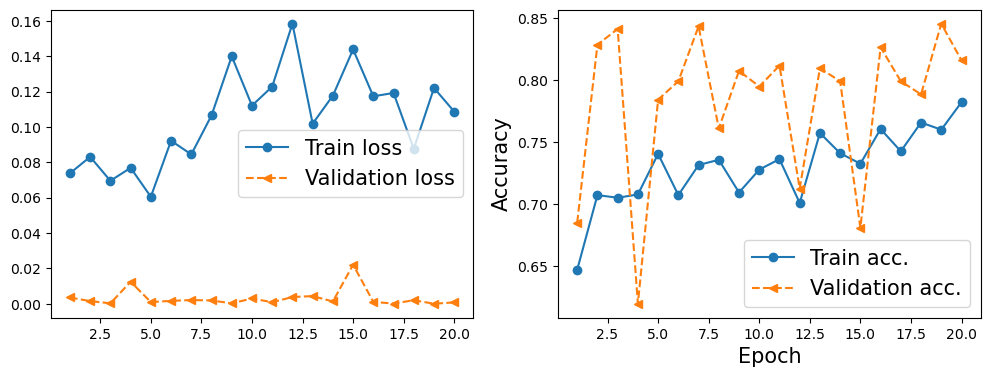

In [34]:
plot_learning_curves(hist)

### Evaluate the model with test dataset

Checking the results of the test dataset…



In [35]:
print("Checking the results of test dataset.")
accu_test, _ = evaluate(model, test_dataloader)
print("test accuracy {:8.3f}".format(accu_test))

Checking the results of test dataset.
test accuracy    0.844


In [36]:
# create confusion matrix
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

def plot_confusion_matrix(model, dataloader):
    model.eval()
    y_test = np.asarray([])
    y_predict = np.asarray([])

    with torch.no_grad():
        for idx, (data, label) in enumerate(dataloader):
            outputs = model(input_ids=data.input_ids, attention_mask=data.attention_mask)
            predicted_label = outputs.logits
                  
            y_test = np.concatenate((y_test, np.asarray(label.to(device='cpu', dtype=torch.long))), axis=None)
            y_predict = np.concatenate((y_predict, np.asarray((predicted_label.argmax(1).to(device='cpu', dtype=torch.long)))), axis=None)

    cm = confusion_matrix(y_test, y_predict)
    sns.heatmap(cm, annot=True, fmt = "d")
    print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

         0.0       0.74      0.97      0.84       109
         1.0       0.97      0.75      0.85       154

    accuracy                           0.84       263
   macro avg       0.86      0.86      0.84       263
weighted avg       0.88      0.84      0.84       263



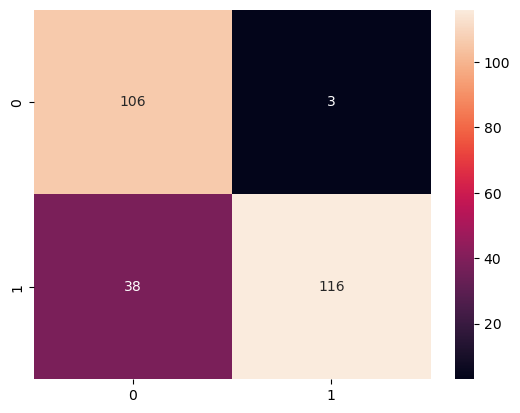

In [37]:
plot_confusion_matrix(model, test_dataloader)

In [38]:
def predict(text):
    with torch.no_grad():
        encoded_text = tokenizer(text)
        encoded_text.input_ids = torch.tensor(encoded_text.input_ids).to(device).unsqueeze(0)
        encoded_text.attention_mask = torch.tensor(encoded_text.attention_mask).to(device).unsqueeze(0)

        outputs = model(input_ids=encoded_text.input_ids, attention_mask=encoded_text.attention_mask)
        predicted_label = outputs.logits
        return predicted_label.argmax(1).item()

In [43]:
ex_text_str = 'The ePump Software shall define Fault ID 1 as follows:'

print("This is a %s" % predict(ex_text_str))

This is a 0


In [44]:
pred_text = "The IO Service shall select the XLR-PW DEV_INFO_DATA file if HPP_XLR_WIRING is grounded (logical 1) and bits AC_TYPE_BIT1 - AC_TYPE_BIT6 do not indicate a CFM engine configuration. NOTE: HPP_XLR_WIRING and bits AC_TYPE_BIT[1-6] are discrete inputs which are received on constant pins between hardware configurations. See 282100-ICD-x for more details."
predict(pred_text)

1

In [45]:
pred_text = "I shall like waffles"
predict(pred_text)

0

In [46]:
pred_text = "Bumblebe is red"
predict(pred_text)

1

In [47]:
pred_text = "Bumblebee is red"
predict(pred_text)

1

In [49]:
today = date.today().isoformat()
model_engine.save_16bit_model("./models/phi/", f"{today}_phi.pth")

[2024-05-08 09:48:01,724] [INFO] [logging.py:96:log_dist] [Rank 0] [Torch] Checkpoint global_step2380 is about to be saved!
[2024-05-08 09:48:01,733] [INFO] [engine.py:3596:save_16bit_model] Saving model weights to ./models/phi/2024-05-08_phi.pth, tag: global_step2380
[2024-05-08 09:48:01,734] [INFO] [torch_checkpoint_engine.py:21:save] [Torch] Saving ./models/phi/2024-05-08_phi.pth...
[2024-05-08 09:48:06,475] [INFO] [torch_checkpoint_engine.py:23:save] [Torch] Saved ./models/phi/2024-05-08_phi.pth.
[2024-05-08 09:48:06,475] [INFO] [torch_checkpoint_engine.py:33:commit] [Torch] Checkpoint global_step2380 is ready now!


True

In [58]:
loaded_state_dict = torch.load("/home/it/environments/Genety/models/phi/2024-05-08_phi.pth", mmap=True)
loaded_state_dict

OrderedDict([('model.embed_tokens.weight',
              tensor([[ 1.6998e-02, -1.3275e-02,  2.0309e-02,  ...,  1.7822e-02,
                        5.1346e-03, -7.7343e-04],
                      [ 9.7351e-03,  5.1636e-02,  1.5656e-02,  ..., -6.7329e-03,
                        6.9389e-03, -1.1322e-02],
                      [-4.6387e-02, -9.0942e-03, -1.1349e-03,  ..., -3.0945e-02,
                        3.8940e-02,  1.3847e-02],
                      ...,
                      [-5.9605e-08,  5.9605e-08, -5.9605e-08,  ...,  1.5140e-05,
                       -1.1206e-05,  1.7762e-05],
                      [-0.0000e+00, -5.9605e-08, -1.1921e-07,  ..., -2.5094e-05,
                        3.7730e-05,  2.0683e-05],
                      [ 0.0000e+00, -5.9605e-08,  5.9605e-08,  ..., -1.6034e-05,
                       -1.5676e-05, -3.5882e-05]], dtype=torch.float16)),
             ('model.layers.0.self_attn.query_key_value.weight',
              tensor([[ 0.0010,  0.0288, -0.0464,  ...,

In [59]:
model.load_state_dict(loaded_state_dict, assign=True)

<All keys matched successfully>

In [60]:
torch.save(model, f"./models/phi/{today}_phi_full.pt")

# Hyperparameter tunning with Ray Tune

In [40]:
import time
from datetime import datetime, date

import ray
import ray.train.torch

from ray import train, tune
from ray.train import RunConfig, ScalingConfig, Checkpoint
from ray.train.torch import TorchTrainer

from ray.tune.schedulers import ASHAScheduler

In [41]:
ray.train.torch.get_device()

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
2024-04-08 17:22:06,152	INFO worker.py:1724 -- Started a local Ray instance.


device(type='cuda', index=0)

In [42]:
from torch.utils.data import DataLoader

# function passed to the DataLoader to process a batch of data as indicated
max_tokens = 50

def collate_batch(batch):
    # Get label and text
    y, x = list(zip(*batch))

    # Create list with indices from tokeniser
    encoded_x = tokenizer(x, padding=True, truncation=True)
    encoded_x.input_ids = torch.tensor(encoded_x.input_ids)
    encoded_x.attention_mask = torch.tensor(encoded_x.attention_mask)
    
    return encoded_x, torch.tensor(y, dtype=torch.long)

In [43]:
def train_func(model, optimizer, train_loader, max_norm):  
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.train()
    
    total_acc, total_count = 0, 0
    log_interval = 5
    start_time = time.time()
    total_loss = 0

    for idx, (encoded_x, label) in enumerate(train_loader):           
        label = label.to(device)
        
        
        encoded_x.input_ids = encoded_x.input_ids.to(device)
        encoded_x.attention_mask = encoded_x.attention_mask.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(input_ids=encoded_x.input_ids, attention_mask=encoded_x.attention_mask)
        predicted_label = outputs.logits
        loss = criterion(predicted_label, label)
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm)
        optimizer.step()
        total_acc += (predicted_label.argmax(1) == label).sum().item()
        total_count += label.size(0)
        total_loss += loss.item()
         
    return total_acc / total_count, total_loss / total_count
        

def eval_func(model, data_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    
    total_acc, total_count = 0, 0

    with torch.no_grad():
        for idx, (encoded_x, label) in enumerate(data_loader):
            label = label.to(device)
            
            encoded_x.input_ids = encoded_x.input_ids.to(device)
            encoded_x.attention_mask = encoded_x.attention_mask.to(device)
            
            outputs = model(input_ids=encoded_x.input_ids, attention_mask=encoded_x.attention_mask)
            predicted_label = outputs.logits
            loss = criterion(predicted_label, label)
            total_acc += (predicted_label.argmax(1) == label).sum().item()
            total_count += label.size(0)

    return total_acc / total_count, loss.item() / total_count

In [44]:
import os
import tempfile

today = date.today().isoformat()
model_name = "roberta_base"
checkpoint_path = f"./models/{model_name}"
num_class = 2

def train_search(config):
    device = "cuda:0" if torch.cuda.is_available() else "cpu"
    # print(device)
    # print(config)
    # config_params = config["params"]
    config_params = config
    # print(config_params)
    
    
    
    
    model = torch.hub.load(
        "huggingface/pytorch-transformers",
        "modelForSequenceClassification",
        "roberta-base"
    )
    
    for i, parameter in enumerate(model.parameters()):
        parameter.requires_grad = False
    
    model.classifier.out_proj = nn.Linear(in_features=768, out_features=num_class)
    model = model.to(device)
    
    

    train_dataloader = DataLoader(
        split_train_, batch_size=config_params["batch_size"], shuffle=True, collate_fn=collate_batch
    )
    valid_dataloader = DataLoader(
        split_valid_, batch_size=config_params["batch_size"], shuffle=True, collate_fn=collate_batch
    )
    test_dataloader = DataLoader(
        test_dataset, batch_size=config_params["batch_size"], shuffle=True, collate_fn=collate_batch
    )
    
    # optimizer = torch.optim.Adam(model.parameters(), lr=config_params["lr"])
    optimizer = torch.optim.SGD(model.parameters(), lr=config_params["lr"], momentum=config_params["momentum"])
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=config_params["step_size"], gamma=config_params["lr_gamma"])
    criterion = torch.nn.CrossEntropyLoss()
    
    for epoch in range(1, config_params["epochs"] + 1):
        epoch_start_time = time.time()
        accu_train, loss_train = train_func(model, optimizer, train_dataloader, config_params["max_norm"])
        accu_val, loss_val = eval_func(model, valid_dataloader)
        
        # Always let the scheduler take a step because it will be optimized by Hyperopt
        scheduler.step()
            
        with tempfile.TemporaryDirectory() as temp_checkpoint_dir:
            checkpoint = None
            if epoch % 5 == 0:
                # This saves the model to the trial directory
                torch.save(
                    model.state_dict(),
                    os.path.join(temp_checkpoint_dir, "model.pth")
                )
                checkpoint = Checkpoint.from_directory(temp_checkpoint_dir)

            # Send the current training result back to Ray Tune
            train.report({
                "loss_train": loss_train,
                "loss_val": loss_val,
                "accuracy_train": accu_train,
                "accuracy_val": accu_val,
            }, checkpoint=checkpoint)

In [45]:
import gc

gc.collect()
torch.cuda.empty_cache()

In [46]:
import numpy as np
from hyperopt import hp
from ray.tune.search.hyperopt import HyperOptSearch

exp_name = model_name

space = {
    "lr": hp.loguniform("lr", -3, 1),
    "momentum": hp.uniform("momentum", 0.01, 0.9),
    "epochs": hp.choice("epochs", [30]),
    "batch_size": hp.choice("batch_size", [16, 32]),
    "step_size": hp.randint("step_size", 1, 10),
    "lr_gamma": hp.uniform("lr_gamma", 0.01, 0.9),
    "max_norm": hp.uniform("max_norm", 0.01, 0.9),
}

hyperopt_search = HyperOptSearch(space, metric="accuracy_val", mode="max")

# Uncomment this to enable distributed execution
# `ray.init(address="auto")`

tuner = tune.Tuner(
    tune.with_resources(train_search, resources={"cpu":8, "gpu":0.5}),
    tune_config=tune.TuneConfig(
        num_samples=30,
        scheduler=ASHAScheduler(metric="accuracy_val", mode="max"), # Early stopping
        search_alg=hyperopt_search, # Hyperopt library for Hyper-parameter Optimization
    ),
    run_config=train.RunConfig(
        name=exp_name,
        checkpoint_config=train.CheckpointConfig(
            checkpoint_score_attribute="accuracy_val",
            num_to_keep=2,
            # checkpoint_at_end=True
        ),
    ),
)
results = tuner.fit()

(train_search pid=139395) Using cache found in /home/it/.cache/torch/hub/huggingface_pytorch-transformers_main
(train_search pid=139485) Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
(train_search pid=139485) You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
(train_search pid=139395) Using cache found in /home/it/.cache/torch/hub/huggingface_pytorch-transformers_main [repeated 2x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/ray-logging.html#log-deduplication for more options.)
(train_search pid=139395) Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and

[<AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>]

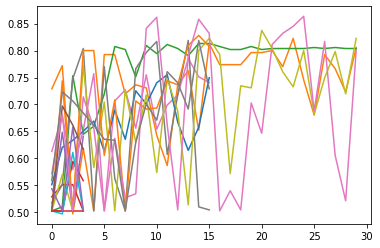

In [47]:
dfs = {result.path: result.metrics_dataframe for result in results}
[d["accuracy_val"].plot() for d in dfs.values()]

In [48]:
best_result = results.get_best_result("accuracy_val", "max")
best_result.config

{'batch_size': 16,
 'epochs': 30,
 'lr': 0.30950058877069947,
 'lr_gamma': 0.8874384348303483,
 'max_norm': 0.13902099797968576,
 'momentum': 0.8077356837534213,
 'step_size': 4}

In [49]:
best_result.metrics_dataframe

,loss_train,loss_val,accuracy_train,accuracy_val,timestamp,checkpoint_dir_name,done,training_iteration,trial_id,date,...,time_since_restore,iterations_since_restore,config/batch_size,config/epochs,config/lr,config/lr_gamma,config/max_norm,config/momentum,config/step_size,should_checkpoint
0,0.046683,0.001157,0.538569,0.502804,1712622638,None,False,1,96cd7c5d,2024-04-08_17-30-38,...,5.293167,1,16,30,0.309501,0.887438,0.139021,0.807736,4,NaN
1,0.043864,0.001106,0.596073,0.570093,1712622648,None,False,2,96cd7c5d,2024-04-08_17-30-48,...,15.655403,2,16,30,0.309501,0.887438,0.139021,0.807736,4,NaN
2,0.041782,0.001874,0.623656,0.502804,1712622659,None,False,3,96cd7c5d,2024-04-08_17-30-59,...,25.976075,3,16,30,0.309501,0.887438,0.139021,0.807736,4,NaN
3,0.040105,0.001218,0.639084,0.771963,1712622669,None,False,4,96cd7c5d,2024-04-08_17-31-09,...,36.305968,4,16,30,0.309501,0.887438,0.139021,0.807736,4,NaN
4,0.042993,0.001235,0.624591,0.583178,1712622680,checkpoint_000000,False,5,96cd7c5d,2024-04-08_17-31-20,...,47.360196,5,16,30,0.309501,0.887438,0.139021,0.807736,4,True
5,0.040554,0.000806,0.655446,0.704673,1712622688,None,False,6,96cd7c5d,2024-04-08_17-31-28,...,55.661068,6,16,30,0.309501,0.887438,0.139021,0.807736,4,NaN
6,0.039787,0.001721,0.671809,0.502804,1712622699,None,False,7,96cd7c5d,2024-04-08_17-31-39,...,66.020274,7,16,30,0.309501,0.887438,0.139021,0.807736,4,NaN
7,0.042306,0.001034,0.652641,0.727103,1712622709,None,False,8,96cd7c5d,2024-04-08_17-31-49,...,76.308627,8,16,30,0.309501,0.887438,0.139021,0.807736,4,NaN
8,0.038799,0.001186,0.673212,0.629907,1712622719,None,False,9,96cd7c5d,2024-04-08_17-31-59,...,86.660007,9,16,30,0.309501,0.887438,0.139021,0.807736,4,NaN
9,0.039226,0.000968,0.657317,0.717757,1712622730,checkpoint_000001,False,10,96cd7c5d,2024-04-08_17-32-10,...,97.827054,10,16,30,0.309501,0.887438,0.139021,0.807736,4,True


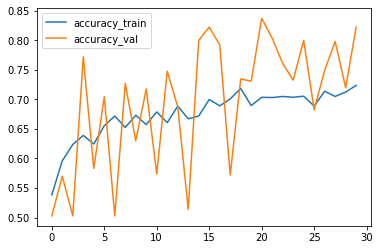

In [50]:
import matplotlib.pyplot as plt

df = best_result.metrics_dataframe

plt.plot(df['accuracy_train'], label='accuracy_train')
plt.plot(df['accuracy_val'], label='accuracy_val')

plt.legend(title='')

plt.show()

In [51]:
best_checkpoints = best_result.best_checkpoints
best_checkpoints

[(Checkpoint(filesystem=local, path=/home/it/ray_results/roberta_base/train_search_96cd7c5d_19_batch_size=16,epochs=30,lr=0.3095,lr_gamma=0.8874,max_norm=0.1390,momentum=0.8077,step_size=4_2024-04-08_17-30-33/checkpoint_000004),
  {'loss_train': 0.037459485870257,
   'loss_val': 0.0006986077143767169,
   'accuracy_train': 0.7054698457223001,
   'accuracy_val': 0.8,
   'timestamp': 1712622856,
   'checkpoint_dir_name': 'checkpoint_000004',
   'should_checkpoint': True,
   'done': False,
   'training_iteration': 25,
   'trial_id': '96cd7c5d',
   'date': '2024-04-08_17-34-16',
   'time_this_iter_s': 3.592725992202759,
   'time_total_s': 223.38375163078308,
   'pid': 139395,
   'hostname': 'coeus',
   'node_ip': '10.1.1.204',
   'config': {'batch_size': 16,
    'epochs': 30,
    'lr': 0.30950058877069947,
    'lr_gamma': 0.8874384348303483,
    'max_norm': 0.13902099797968576,
    'momentum': 0.8077356837534213,
    'step_size': 4},
   'time_since_restore': 223.38375163078308,
   'iteratio

In [52]:
best_checkpoint = best_result.get_best_checkpoint("accuracy_val", mode="max")

In [53]:
next(x for x in best_checkpoints if x[0].path == best_checkpoint.path)

(Checkpoint(filesystem=local, path=/home/it/ray_results/roberta_base/train_search_96cd7c5d_19_batch_size=16,epochs=30,lr=0.3095,lr_gamma=0.8874,max_norm=0.1390,momentum=0.8077,step_size=4_2024-04-08_17-30-33/checkpoint_000005),
 {'loss_train': 0.03523503265519073,
  'loss_val': 0.0005899809231267911,
  'accuracy_train': 0.7237026647966339,
  'accuracy_val': 0.822429906542056,
  'timestamp': 1712622919,
  'checkpoint_dir_name': 'checkpoint_000005',
  'should_checkpoint': True,
  'done': False,
  'training_iteration': 30,
  'trial_id': '96cd7c5d',
  'date': '2024-04-08_17-35-20',
  'time_this_iter_s': 13.769116401672363,
  'time_total_s': 286.8854925632477,
  'pid': 139395,
  'hostname': 'coeus',
  'node_ip': '10.1.1.204',
  'config': {'batch_size': 16,
   'epochs': 30,
   'lr': 0.30950058877069947,
   'lr_gamma': 0.8874384348303483,
   'max_norm': 0.13902099797968576,
   'momentum': 0.8077356837534213,
   'step_size': 4},
  'time_since_restore': 286.8854925632477,
  'iterations_since_re

In [54]:
state_dict = torch.load(os.path.join(best_checkpoint.path, "model.pth"))

num_class = 2
model = torch.hub.load(
    "huggingface/pytorch-transformers",
    "modelForSequenceClassification",
    "roberta-base"
)
model.classifier.out_proj = nn.Linear(in_features=768, out_features=num_class)

model.load_state_dict(state_dict)

Using cache found in /home/it/.cache/torch/hub/huggingface_pytorch-transformers_main
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


<All keys matched successfully>

In [55]:
uq_path = today + "_" + "_".join(best_result.path.split("=")[0].split("/")[-2:])
save_path = os.path.join(f'./models/{model_name}', uq_path + "_model.pt")
torch.save(model, save_path)